In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [116]:
data = []
for i in range(10):
    data.append(pd.read_csv(f"div_{i}.csv"))
df = pd.concat(data)
# df = pd.read_csv("del_0.csv")

In [117]:
divs = len(df[(df['i'] > 0) &( df['next']=="div")])
dels = len(df[(df['i'] > 0) &(df['next']=="del")])
nbs = len(df[(df['i'] > 0) &(df['next']=="none")])
total = divs + dels + nbs

In [118]:
# can get baseline ratio easily here then.

One thing to look at is why this drops off here a bit-- not super concerning but a bit weird.

In [119]:
print (divs/total, dels/total, nbs/total, total)

0.09490237370384783 0.09474214297159338 0.8103554833245588 43687


In [73]:
# to get predictions based on div/del, need to transform the dataset
# for every cell that divs (dels), find the distance to every other cell at that time. 
# for every cell within a certain range, track its actions over the next several timesteps
# at each timestep, for every cell that in frame t-1 was in the range of a del, look at the number of divs/dels, and nbs
# then t-2
# t-3 .... etc
# probably not going to be super efficient, so just let this run over a while and start writing up the paper at the same time.

In [74]:
# also, try the above with several different distance ranges to get a sense for how far everything propagates

In [75]:
cutoff = 0.1
adiv = df[(df['i']==20) & (df['next']=="div")]
timestep = df[(df['i']==20)].copy()
close = []
for i in range(len(adiv)):
    timestep['distance'] = np.sqrt(np.power(timestep['x'] - adiv.iat[i,4],2) + np.power(timestep['y'] - adiv.iat[i,5],2))
    close.append(timestep[timestep['distance']< cutoff])

In [76]:
close = pd.concat(close)
# then just get the unique ids?

In [77]:
unique = close['id'].unique()

In [78]:
step = df[(df['id'].isin(unique))]

In [81]:
def get_ratio(df, distance, time, t):
    """
    distance and time are cutoffs
    t is div/del
    """
    data = []
    for i in range(20,301, 20):
        events = df[(df['i']==i) & (df['next']==t)]
        snapshot = df[(df['i']==i)].copy()
        close = []
        for j in range(len(events)):
            snapshot['distance'] = np.sqrt(np.power(snapshot['x'] - events.iat[j,5],2) + np.power(snapshot['y'] - events.iat[j,6],2))
            close.append(snapshot[(snapshot['distance']< distance) & (snapshot['distance'] >1e-6)])
        close = pd.concat(close)['id'].unique()
        data.append(df[(df['id'].isin(close)) & (df['i']== i + 20*time)].copy())
    return pd.concat(data)

In [136]:
d = get_ratio(df, .1, 3, "div")

In [137]:
d.groupby('next').count()

,Unnamed: 0,parent,id,i,x,y
next,,,,,,
del,2853,2853,2853,2853,2853,2853
div,2498,2498,2498,2498,2498,2498
none,14666,14666,14666,14666,14666,14666


In [138]:
dels = d.groupby('next').count().at['del','id']
divs = d.groupby('next').count().at['div','id']
nbs = d.groupby('next').count().at['none','id']

In [139]:
total = dels + divs + nbs
print (dels/total, divs/total, nbs/total)

0.14252885047709446 0.12479392516361093 0.7326772243592946


Honestly, not sure this is going to give me anything very useful at all. Hopefully it does in the end, but we'll see.

In [87]:
del_info = []
div_info = []
for distance in np.linspace(0,.2,10):
    if distance == 0:
        continue
    for time in range (1,7):
        d = get_ratio(df,distance,time,"del")
        dels = d.groupby('next').count().at['del','id']
        divs = d.groupby('next').count().at['div','id']
        nbs = d.groupby('next').count().at['none','id']
        total = dels + divs + nbs
        del_info.append((distance, time, dels, divs, nbs,total))

In [88]:
for distance in np.linspace(0,.2,10):
    if distance == 0:
        continue
    for time in range (1,7):
        d = get_ratio(df,distance,time,"div")
        try:
            dels = d.groupby('next').count().at['del','id']
        except:
            dels = 0
        try:
            divs = d.groupby('next').count().at['div','id']
        except:
            divs = 0
        nbs = d.groupby('next').count().at['none','id']
        total = dels + divs + nbs
        div_info.append((distance, time, dels, divs, nbs,total))

In [89]:
nb_info = []
for distance in np.linspace(0,.2,10):
    if distance == 0:
        continue
    for time in range (1,7):
        d = get_ratio(df,distance,time,"none")
        dels = d.groupby('next').count().at['del','id']
        divs = d.groupby('next').count().at['div','id']
        nbs = d.groupby('next').count().at['none','id']
        total = dels + divs + nbs
        nb_info.append((distance, time, dels, divs, nbs,total))

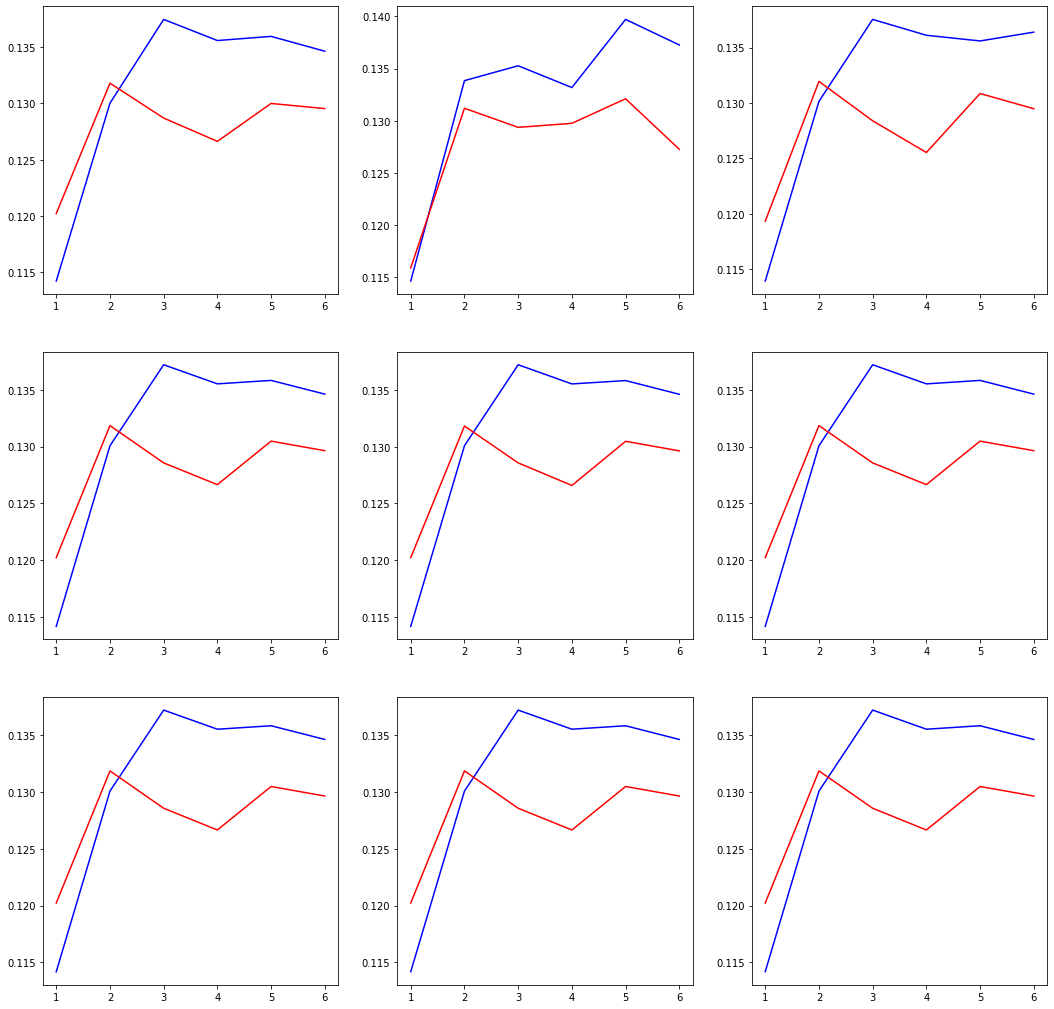

In [90]:
fig,ax = plt.subplots(3,3, figsize=(18,18))
for i,d in enumerate(np.linspace(0,.2,10)):
    if i ==0:
        continue
    dd= [x for x in div_info if np.abs(x[0] - d) < 1e-6]
    ax[int((i-1) / 3), i % 3].plot([x[1] for x in dd], [x[3]/x[5] for x in dd],color = 'b')
    ax[int((i-1) / 3), i % 3].plot([x[1] for x in dd], [x[2]/x[5] for x in dd],color = 'r')

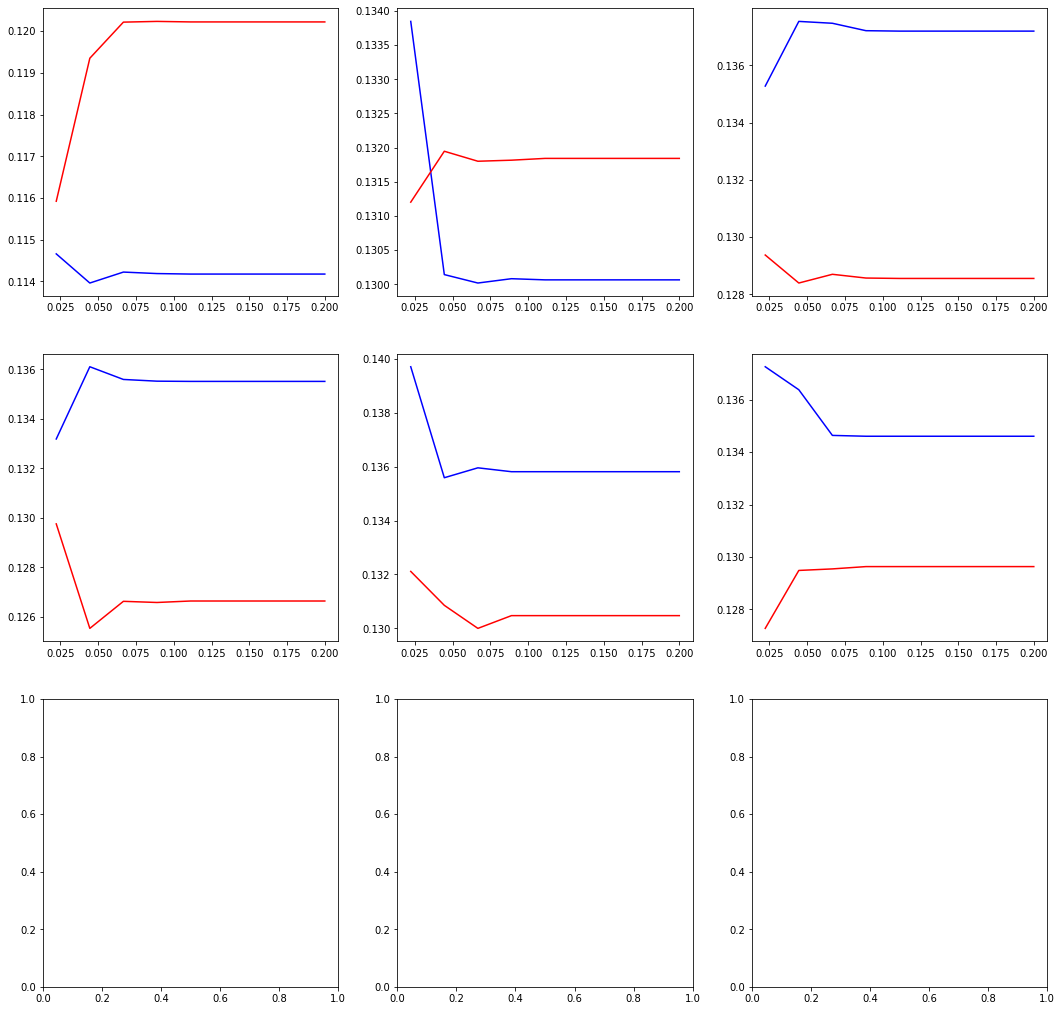

In [91]:
fig,ax = plt.subplots(3,3, figsize=(18,18))
for i,d in enumerate(range(1,7)):
    dd= [x for x in div_info if np.abs(x[1] - d) < 1e-6]
    ax[int((i) / 3), i % 3].plot([x[0] for x in dd], [x[3]/x[5] for x in dd],color = 'b')
    ax[int((i) / 3), i % 3].plot([x[0] for x in dd], [x[2]/x[5] for x in dd],color = 'r')

In [106]:
old = df[df['i']> 60]

In [108]:
old[old['i']% 20 ==0].groupby('next').count()

,Unnamed: 0,id,i,x,y
next,,,,,
del,2277,2277,2277,2277,2277
div,2509,2509,2509,2509,2509
none,21479,21479,21479,21479,21479


In [109]:
t = 2277 + 2509 + 21479

In [110]:
2277 /t 

0.08669331810394061

In [111]:
2509 / t

0.09552636588616029

Sanity check-- can I see the divs/dels that were influenced by the other one? for a couple examples, get the 6 closest neighbors and look for the timestep where the next div/del happened.

Also-- look at the distances to these neighbors-- do I need to change the grid search? Look at the times -should be 1-2 timesteps after?

if distances are consistent, the rate of response should go to at least 1/6 which should be visible in the data analysis?